In [90]:
import pandas as pd
from pandas import datetime 
from pmdarima import auto_arima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
import matplotlib.pyplot as plt
import glob, os

In [2]:
file='C:\\Users\\kb0365\\Time Series Analysis\\MemoryUtilization1.csv'
df_Memory=pd.read_csv(file) 
# convert datetime datatype
df_Memory['Timestamp'] = pd.to_datetime(df_Memory['Timestamp']) 
df_Memory['hr'] = df_Memory['Timestamp'].apply(lambda x:x.hour)
df_Memory['Date']= df_Memory['Timestamp'].apply(lambda x:x.date())
df_Memory['value']=df_Memory['Maximum']
# Remove Unwanted column
del df_Memory['Unit']
del df_Memory['Timestamp'] 
del df_Memory['Maximum']
df_Memory['Date_Hr'] = df_Memory[['Date','hr']].apply(lambda x : '{}{}'.format(x[0],x[1]), axis=1) 
#df_perc_5=preparePercentileData(df_Memory,5) 
#df_perc_90=preparePercentileData(df_Memory,90)  

In [3]:
df_Memory

,hr,Date,value,Date_Hr
0,0,2018-08-01,21.100975,2018-08-010
1,0,2018-08-01,21.090166,2018-08-010
2,0,2018-08-01,21.097491,2018-08-010
3,0,2018-08-01,21.100005,2018-08-010
4,0,2018-08-01,21.089546,2018-08-010
5,0,2018-08-01,21.089071,2018-08-010
6,0,2018-08-01,21.101919,2018-08-010
7,0,2018-08-01,21.091315,2018-08-010
8,0,2018-08-01,21.103800,2018-08-010
9,0,2018-08-01,21.099755,2018-08-010


In [4]:
def hourlyPercentileDataPrepare(group_testdata,percentile):
    perConvert=percentile/100
    group_testdata['sequence']=group_testdata.groupby('Date_Hr').cumcount()
    group_testdata['sequence']=group_testdata['sequence']+1
    group_testdata['count_max'] = group_testdata.groupby(['Date_Hr'])['sequence'].transform(max)
    group_testdata['percentile'] =round(perConvert*group_testdata['count_max'])  
    group_testdata['PrecentileInput']=percentile
    df_percentileOutput= group_testdata[(group_testdata.sequence == group_testdata.percentile)]
    return(df_percentileOutput)

In [5]:
def dailyPercentileDataPrepare(df_Memory_test,percentile):
    perConvert=percentile/100
    df_Memory_test['sequence']=df_Memory_test.groupby('Date').cumcount()
    df_Memory_test['sequence']=df_Memory_test['sequence']+1
    df_Memory_test['count_max'] =df_Memory_test.groupby(['Date'])['sequence'].transform(max)
    df_Memory_test['percentile'] =round(perConvert*df_Memory_test['count_max']) 
    df_Memory_test['PrecentileInput']=percentile
    df_percentileOutput= df_Memory_test[(df_Memory_test.sequence == df_Memory_test.percentile)]
    return(df_percentileOutput)

In [79]:
def modelFit(df_percentileOutput,Interval,percentile,flag):
    rmse_list=[]
    train = df_percentileOutput[:int(0.7*(len(df_percentileOutput)))]
    valid = df_percentileOutput[int(0.7*(len(df_percentileOutput))):]
    fitModel = auto_arima(train['value'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True,
                           stepwise=True)
    print("AIC of a model:",fitModel.aic())
    fitModel.fit(train['value'])
    future_forecast = fitModel.predict(n_periods=Interval)
    actual= valid['value'].head(Interval)
    actual_date= valid['Date'].head(Interval)
    actual_hr= valid['hr'].head(Interval)
    mse_val=mse(actual,future_forecast)
    print("MSE:",mse_val)
    rmse=sqrt(mse_val)
    print("RMSE:",rmse)
    for temp in range(0,Interval):
        rmse_list.append(rmse)
    data_df={'Date':actual_date,'Hour':actual_hr,'Actual':actual,'Predicted':future_forecast,'Percentile':percentile}
    results=pd.DataFrame(data=data_df)
    results["RMSE"]=rmse
    results["Flag"]=flag
    plt.plot(results['Actual'])
    plt.plot(results['Predicted'],color='red')
    plt.xlabel('Years')
    plt.ylabel('Values')
    plt.show()
    return(results)


In [80]:
def writetocsv(results,percentile,flag):
    filename="output"+"_"+str(percentile)+"_"+flag+'.csv'
    results.to_csv(filename,sep=',', encoding='utf-8')

In [81]:
df_percentileOutputhr_60=hourlyPercentileDataPrepare(df_Memory,60)
df_percentileOutputhr_70=hourlyPercentileDataPrepare(df_Memory,70)
df_percentileOutputhr_80=hourlyPercentileDataPrepare(df_Memory,80)
df_percentileOutputhr_90=hourlyPercentileDataPrepare(df_Memory,90)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6842.837, BIC=6869.525, Fit time=2.238 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=7987.362, BIC=7998.037, Fit time=0.062 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=7466.493, BIC=7487.844, Fit time=0.427 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6842.961, BIC=6864.311, Fit time=1.398 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=6844.082, BIC=6876.107, Fit time=3.831 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=7903.623, BIC=7924.973, Fit time=0.361 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=6844.276, BIC=6876.302, Fit time=4.481 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=6846.836, BIC=6884.199, Fit time=3.071 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6843.151, BIC=6875.176, Fit time=2.121 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_o

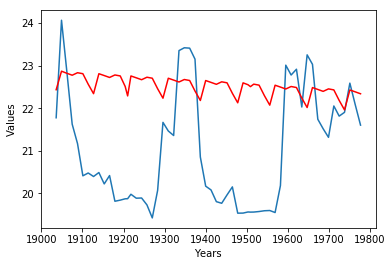

In [82]:
model_output=modelFit(df_percentileOutputhr_60,60,60,"Hour")

In [83]:
writetocsv(model_output,60,"hour")

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6778.980, BIC=6805.668, Fit time=2.046 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=7883.245, BIC=7893.920, Fit time=0.172 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=7388.934, BIC=7410.284, Fit time=0.398 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6780.922, BIC=6802.272, Fit time=1.593 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=6780.627, BIC=6812.652, Fit time=3.380 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=7824.282, BIC=7845.633, Fit time=0.328 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=6780.617, BIC=6812.642, Fit time=5.127 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=6783.161, BIC=6820.524, Fit time=3.578 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6792.829, BIC=6824.854, Fit time=1.634 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_o

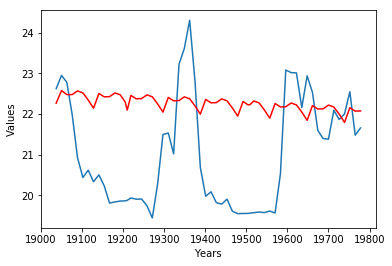

             Date  Hour     Actual  Predicted  Percentile      RMSE  Flag
19037  2018-10-04     9  22.625164  22.268406          70  1.866962  Hour
19050  2018-10-04    10  22.951484  22.579482          70  1.866962  Hour
19063  2018-10-04    11  22.782266  22.479841          70  1.866962  Hour
19076  2018-10-04    12  21.989648  22.480381          70  1.866962  Hour
19089  2018-10-04    13  20.925884  22.570641          70  1.866962  Hour
19102  2018-10-04    14  20.439354  22.522989          70  1.866962  Hour
19115  2018-10-04    15  20.620668  22.347596          70  1.866962  Hour
19128  2018-10-04    16  20.335895  22.146086          70  1.866962  Hour
19141  2018-10-04    17  20.505126  22.507728          70  1.866962  Hour
19154  2018-10-04    18  20.234832  22.424336          70  1.866962  Hour
19167  2018-10-04    19  19.810609  22.430057          70  1.866962  Hour
19180  2018-10-04    20  19.839381  22.521929          70  1.866962  Hour
19193  2018-10-04    21  19.859250  22

In [42]:
modelFit(df_percentileOutputhr_70,60,70,"Hour")

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=5930.964, BIC=5957.652, Fit time=2.360 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=7034.972, BIC=7045.647, Fit time=0.047 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=6645.091, BIC=6666.442, Fit time=0.336 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=5974.545, BIC=5995.895, Fit time=1.673 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=5932.886, BIC=5964.911, Fit time=2.336 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=6961.619, BIC=6982.970, Fit time=0.338 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=5932.871, BIC=5964.897, Fit time=3.701 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=5932.650, BIC=5970.013, Fit time=5.771 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=5926.664, BIC=5958.689, Fit time=2.573 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_o

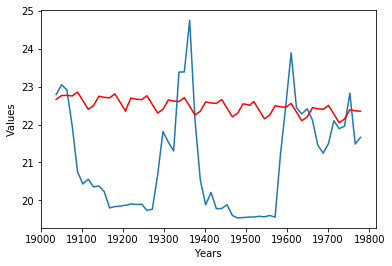

             Date  Hour     Actual  Predicted  Percentile      RMSE  Flag
19038  2018-10-04     9  22.790568  22.664760          80  2.025894  Hour
19051  2018-10-04    10  23.046311  22.762910          80  2.025894  Hour
19064  2018-10-04    11  22.916028  22.768227          80  2.025894  Hour
19077  2018-10-04    12  21.966407  22.753498          80  2.025894  Hour
19090  2018-10-04    13  20.757749  22.854373          80  2.025894  Hour
19103  2018-10-04    14  20.434022  22.627831          80  2.025894  Hour
19116  2018-10-04    15  20.561046  22.400840          80  2.025894  Hour
19129  2018-10-04    16  20.354940  22.499087          80  2.025894  Hour
19142  2018-10-04    17  20.381890  22.744726          80  2.025894  Hour
19155  2018-10-04    18  20.231268  22.716513          80  2.025894  Hour
19168  2018-10-04    19  19.803146  22.703912          80  2.025894  Hour
19181  2018-10-04    20  19.837493  22.806555          80  2.025894  Hour
19194  2018-10-04    21  19.850038  22

In [43]:
modelFit(df_percentileOutputhr_80,60,80,"Hour")

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=7050.077, BIC=7076.764, Fit time=2.425 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=8192.800, BIC=8203.475, Fit time=0.104 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=7691.874, BIC=7713.224, Fit time=0.647 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=7049.086, BIC=7070.436, Fit time=1.406 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=7051.043, BIC=7077.731, Fit time=1.512 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=8067.947, BIC=8083.960, Fit time=0.159 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=7051.040, BIC=7077.728, Fit time=3.692 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=7051.415, BIC=7083.441, Fit time=2.358 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=7187.052, BIC=7203.064, Fit time=0.883 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_o

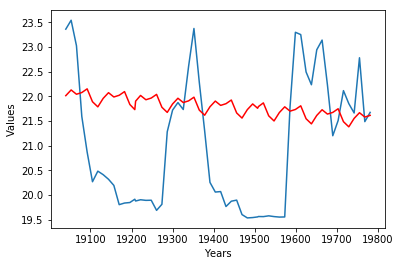

             Date  Hour     Actual  Predicted  Percentile      RMSE  Flag
19040  2018-10-04     9  23.364218  22.014700          90  1.559533  Hour
19053  2018-10-04    10  23.544944  22.130541          90  1.559533  Hour
19066  2018-10-04    11  23.026996  22.043390          90  1.559533  Hour
19079  2018-10-04    12  21.592026  22.078082          90  1.559533  Hour
19092  2018-10-04    13  20.869694  22.152721          90  1.559533  Hour
19105  2018-10-04    14  20.268183  21.891083          90  1.559533  Hour
19118  2018-10-04    15  20.483013  21.787687          90  1.559533  Hour
19131  2018-10-04    16  20.411533  21.959351          90  1.559533  Hour
19144  2018-10-04    17  20.318012  22.075098          90  1.559533  Hour
19157  2018-10-04    18  20.193502  21.987853          90  1.559533  Hour
19170  2018-10-04    19  19.803271  22.022451          90  1.559533  Hour
19183  2018-10-04    20  19.835929  22.096998          90  1.559533  Hour
19196  2018-10-04    21  19.846329  21

In [44]:
modelFit(df_percentileOutputhr_90,60,90,"Hour")

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6778.980, BIC=6805.668, Fit time=2.108 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=7883.245, BIC=7893.920, Fit time=0.062 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=7388.934, BIC=7410.284, Fit time=0.438 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6780.922, BIC=6802.272, Fit time=2.503 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=6780.627, BIC=6812.652, Fit time=5.263 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=7824.282, BIC=7845.633, Fit time=0.446 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=6780.617, BIC=6812.642, Fit time=6.428 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=6783.161, BIC=6820.524, Fit time=4.091 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6792.829, BIC=6824.854, Fit time=1.758 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_o

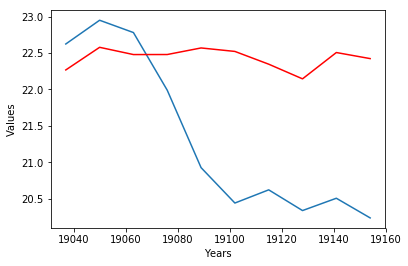

            Date_Hr     Actual  Predicted  Percentile
19037   2018-10-049  22.625164  22.268406          70
19050  2018-10-0410  22.951484  22.579482          70
19063  2018-10-0411  22.782266  22.479841          70
19076  2018-10-0412  21.989648  22.480381          70
19089  2018-10-0413  20.925884  22.570641          70
19102  2018-10-0414  20.439354  22.522989          70
19115  2018-10-0415  20.620668  22.347596          70
19128  2018-10-0416  20.335895  22.146086          70
19141  2018-10-0417  20.505126  22.507728          70
19154  2018-10-0418  20.234832  22.424336          70


In [20]:
modelFit(df_percentileOutputhr_70,10,70,"Hour")


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6842.837, BIC=6869.525, Fit time=2.382 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=7987.362, BIC=7998.037, Fit time=0.063 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=7466.493, BIC=7487.844, Fit time=0.505 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6842.961, BIC=6864.311, Fit time=1.472 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=6844.082, BIC=6876.107, Fit time=3.854 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=7903.623, BIC=7924.973, Fit time=0.377 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=6844.276, BIC=6876.302, Fit time=5.021 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=6846.836, BIC=6884.199, Fit time=3.086 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6843.151, BIC=6875.176, Fit time=2.140 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_o

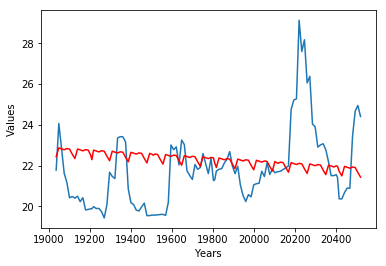

            Date_Hr     Actual  Predicted  Percentile
19036   2018-10-049  21.776283  22.434365          60
19049  2018-10-0410  24.064747  22.869181          60
19062  2018-10-0411  22.860754  22.820353          60
19075  2018-10-0412  21.625687  22.774917          60
19088  2018-10-0413  21.169427  22.833200          60
19101  2018-10-0414  20.414159  22.810195          60
19114  2018-10-0415  20.480585  22.563800          60
19127  2018-10-0416  20.398143  22.341848          60
19140  2018-10-0417  20.491282  22.809943          60
19153  2018-10-0418  20.224313  22.766805          60
19166  2018-10-0419  20.420441  22.722287          60
19179  2018-10-0420  19.817320  22.780663          60
19192  2018-10-0421  19.843683  22.757608          60
19204  2018-10-0422  19.874989  22.511138          60
19210  2018-10-0423  19.877351  22.289107          60
19218   2018-10-050  19.981444  22.757122          60
19231   2018-10-051  19.889177  22.713904          60
19244   2018-10-052  19.8936

In [22]:
modelFit(df_percentileOutputhr_60,120,60,"Hour")

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6778.980, BIC=6805.668, Fit time=3.932 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=7883.245, BIC=7893.920, Fit time=0.103 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=7388.934, BIC=7410.284, Fit time=0.794 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6780.922, BIC=6802.272, Fit time=2.124 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=6780.627, BIC=6812.652, Fit time=3.951 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=7824.282, BIC=7845.633, Fit time=0.245 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=6780.617, BIC=6812.642, Fit time=5.284 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=6783.161, BIC=6820.524, Fit time=3.701 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=6792.829, BIC=6824.854, Fit time=1.728 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_o

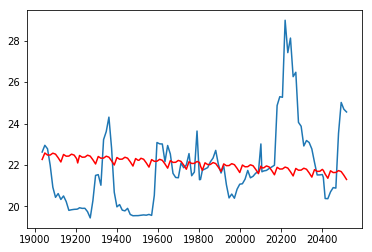

          Actual  Predicted
19037  22.625164  22.268406
19050  22.951484  22.579482
19063  22.782266  22.479841
19076  21.989648  22.480381
19089  20.925884  22.570641
19102  20.439354  22.522989
19115  20.620668  22.347596
19128  20.335895  22.146086
19141  20.505126  22.507728
19154  20.234832  22.424336
19167  19.810609  22.430057
19180  19.839381  22.521929
19193  19.859250  22.474737
19205  19.865790  22.299434
19210  19.877351  22.097894
19219  19.936043  22.459468
19232  19.905912  22.375994
19245  19.909752  22.381630
19258  19.745589  22.473415
19271  19.445342  22.426137
19284  20.280299  22.250747
19297  21.497232  22.049119
19310  21.534344  22.410606
19323  21.022804  22.327046
19336  23.224049  22.332594
19349  23.614174  22.424292
19362  24.309728  22.376927
19375  22.809645  22.201450
19388  20.686183  21.999735
19401  19.978890  22.361135
...          ...        ...
20155  21.906244  21.730341
20168  21.988276  21.527843
20181  24.870338  21.888459
20194  25.296620  21

In [92]:
modelFit(df_percentileOutputhr_70,120,70,"Hour")

In [45]:
df_percentileOutputday_60=dailyPercentileDataPrepare(df_Memory,60)
df_percentileOutputday_70=dailyPercentileDataPrepare(df_Memory,70)
df_percentileOutputday_80=dailyPercentileDataPrepare(df_Memory,80)
df_percentileOutputday_90=dailyPercentileDataPrepare(df_Memory,90)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=388.896, BIC=399.023, Fit time=0.422 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=415.869, BIC=419.919, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=402.512, BIC=410.614, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=391.024, BIC=399.125, Fit time=0.177 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=390.829, BIC=402.981, Fit time=0.354 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=416.234, BIC=424.336, Fit time=0.117 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=391.025, BIC=399.126, Fit

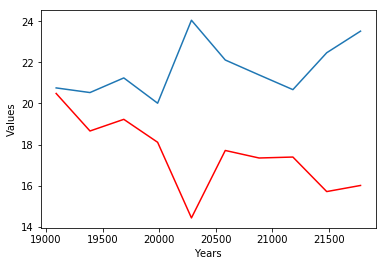

             Date  Hour     Actual  Predicted  Percentile      RMSE   Flag
19090  2018-10-04    13  20.757749  20.487253          60  5.025123  Daily
19389  2018-10-05    13  20.531898  18.660567          60  5.025123  Daily
19688  2018-10-06    13  21.244246  19.227800          60  5.025123  Daily
19987  2018-10-07    13  20.012967  18.110775          60  5.025123  Daily
20286  2018-10-08    13  24.052182  14.428612          60  5.025123  Daily
20585  2018-10-09    13  22.116705  17.711992          60  5.025123  Daily
20884  2018-10-10    13  21.390308  17.345705          60  5.025123  Daily
21183  2018-10-11    13  20.673796  17.392094          60  5.025123  Daily
21482  2018-10-12    13  22.469810  15.711065          60  5.025123  Daily
21781  2018-10-13    13  23.521234  16.008876          60  5.025123  Daily


In [46]:
modelFit(df_percentileOutputday_60,10,60,"Daily")

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=388.493, BIC=398.620, Fit time=0.439 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=413.699, BIC=417.750, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=400.132, BIC=408.233, Fit time=0.123 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=389.980, BIC=398.081, Fit time=0.187 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=391.650, BIC=403.802, Fit time=0.773 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=414.854, BIC=422.956, Fit time=0.147 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=389.980, BIC=398.081, Fit

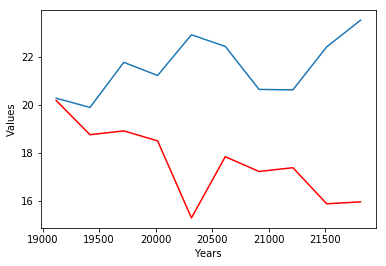

             Date  Hour     Actual  Predicted  Percentile      RMSE   Flag
19120  2018-10-04    16  20.281315  20.186568          70  4.674748  Daily
19419  2018-10-05    16  19.897010  18.759867          70  4.674748  Daily
19718  2018-10-06    16  21.774778  18.918974          70  4.674748  Daily
20017  2018-10-07    16  21.229134  18.502989          70  4.674748  Daily
20316  2018-10-08    16  22.925306  15.292882          70  4.674748  Daily
20615  2018-10-09    16  22.439778  17.843652          70  4.674748  Daily
20914  2018-10-10    16  20.647367  17.228054          70  4.674748  Daily
21213  2018-10-11    16  20.628501  17.385167          70  4.674748  Daily
21512  2018-10-12    16  22.422093  15.880939          70  4.674748  Daily
21811  2018-10-13    16  23.530031  15.962519          70  4.674748  Daily


In [48]:
modelFit(df_percentileOutputday_70,10,70,"Daily")

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=388.467, BIC=398.594, Fit time=0.253 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=414.819, BIC=418.870, Fit time=0.000 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=400.395, BIC=408.496, Fit time=0.084 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=390.389, BIC=398.490, Fit time=0.078 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=390.283, BIC=402.435, Fit time=0.354 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=414.856, BIC=422.957, Fit time=0.069 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=390.244, BIC=402.396, Fit time=0.280 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=390.390, BIC=39

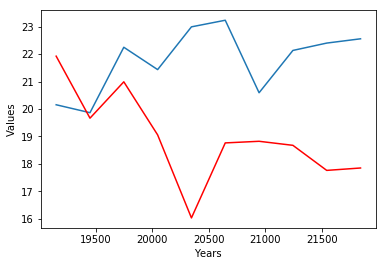

             Date  Hour     Actual  Predicted  Percentile      RMSE   Flag
19150  2018-10-04    18  20.154093  21.926123          80  3.712616  Daily
19449  2018-10-05    18  19.864734  19.665400          80  3.712616  Daily
19748  2018-10-06    18  22.250896  20.990667          80  3.712616  Daily
20047  2018-10-07    18  21.436072  19.056528          80  3.712616  Daily
20346  2018-10-08    18  22.995156  16.027829          80  3.712616  Daily
20645  2018-10-09    18  23.236039  18.762950          80  3.712616  Daily
20944  2018-10-10    18  20.592055  18.822126          80  3.712616  Daily
21243  2018-10-11    18  22.135004  18.674869          80  3.712616  Daily
21542  2018-10-12    18  22.403187  17.760798          80  3.712616  Daily
21841  2018-10-13    18  22.559359  17.848118          80  3.712616  Daily


In [47]:
modelFit(df_percentileOutputday_80,10,80,"Daily")

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=386.960, BIC=397.087, Fit time=0.232 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=411.359, BIC=415.409, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=397.422, BIC=405.523, Fit time=0.069 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=387.025, BIC=395.127, Fit time=0.085 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=388.756, BIC=400.908, Fit time=0.384 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=414.315, BIC=422.417, Fit time=0.047 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=387.011, BIC=395.112, Fit

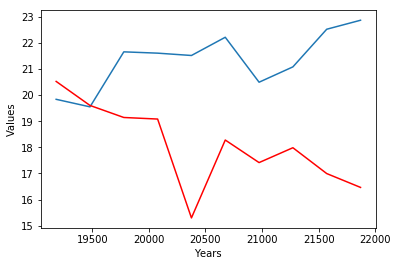

             Date  Hour     Actual  Predicted  Percentile      RMSE   Flag
19180  2018-10-04    20  19.839381  20.525068          90  3.977018  Daily
19479  2018-10-05    20  19.550582  19.604589          90  3.977018  Daily
19778  2018-10-06    20  21.658781  19.143286          90  3.977018  Daily
20077  2018-10-07    20  21.608570  19.083272          90  3.977018  Daily
20376  2018-10-08    20  21.519285  15.294289          90  3.977018  Daily
20675  2018-10-09    20  22.217670  18.279284          90  3.977018  Daily
20974  2018-10-10    20  20.495010  17.414785          90  3.977018  Daily
21273  2018-10-11    20  21.082683  17.984135          90  3.977018  Daily
21572  2018-10-12    20  22.525229  16.994084          90  3.977018  Daily
21871  2018-10-13    20  22.869848  16.463211          90  3.977018  Daily


In [49]:
modelFit(df_percentileOutputday_90,10,90,"Daily")

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=388.493, BIC=398.620, Fit time=0.269 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=413.699, BIC=417.750, Fit time=0.000 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=400.132, BIC=408.233, Fit time=0.078 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=389.980, BIC=398.081, Fit time=0.100 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=391.650, BIC=403.802, Fit time=0.470 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=414.854, BIC=422.956, Fit time=0.085 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=389.980, BIC=398.081, Fit

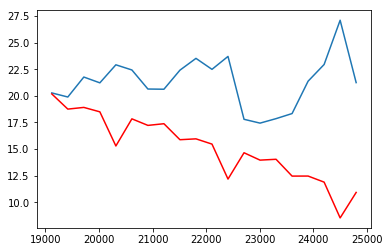

          Actual  Predicted
19120  20.281315  20.186568
19419  19.897010  18.759867
19718  21.774778  18.918974
20017  21.229134  18.502989
20316  22.925306  15.292882
20615  22.439778  17.843652
20914  20.647367  17.228054
21213  20.628501  17.385167
21512  22.422093  15.880939
21811  23.530031  15.962519
22110  22.498166  15.469005
22409  23.713463  12.181371
22708  17.800867  14.654613
23007  17.441262  13.961487
23306  17.863089  14.041073
23605  18.341073  12.459317
23904  21.384851  12.463369
24203  22.955569  11.892328
24502  27.115704   8.527166
24801  21.249888  10.922880


In [96]:
modelFit(df_percentileOutputday_60,20,60,"Daily")

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=388.493, BIC=398.620, Fit time=0.301 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=413.699, BIC=417.750, Fit time=0.000 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=400.132, BIC=408.233, Fit time=0.069 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=389.980, BIC=398.081, Fit time=0.116 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=391.650, BIC=403.802, Fit time=0.451 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=414.854, BIC=422.956, Fit time=0.100 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=389.980, BIC=398.081, Fit

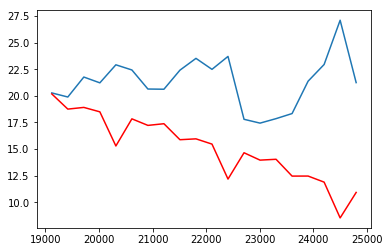

          Actual  Predicted
19120  20.281315  20.186568
19419  19.897010  18.759867
19718  21.774778  18.918974
20017  21.229134  18.502989
20316  22.925306  15.292882
20615  22.439778  17.843652
20914  20.647367  17.228054
21213  20.628501  17.385167
21512  22.422093  15.880939
21811  23.530031  15.962519
22110  22.498166  15.469005
22409  23.713463  12.181371
22708  17.800867  14.654613
23007  17.441262  13.961487
23306  17.863089  14.041073
23605  18.341073  12.459317
23904  21.384851  12.463369
24203  22.955569  11.892328
24502  27.115704   8.527166
24801  21.249888  10.922880


In [97]:
modelFit(df_percentileOutputday_70,20,70,"Daily")

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=388.896, BIC=399.023, Fit time=0.289 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=415.869, BIC=419.919, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=402.512, BIC=410.614, Fit time=0.070 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=391.024, BIC=399.125, Fit time=0.190 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=390.829, BIC=402.981, Fit time=0.386 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=416.234, BIC=424.336, Fit time=0.101 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=391.025, BIC=399.126, Fit

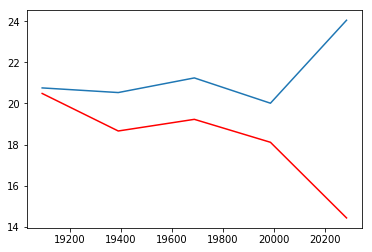

          Actual  Predicted
19090  20.757749  20.487253
19389  20.531898  18.660567
19688  21.244246  19.227800
19987  20.012967  18.110775
20286  24.052182  14.428612


In [105]:
modelFit(df_percentileOutput,5)

In [92]:
os.chdir("C:\\Users\\kb0365\\Time Series Analysis")
results = pd.DataFrame([])
for counter, file in enumerate(glob.glob("output*")):
    namedf = pd.read_csv(file, skiprows=0, usecols=[1,2,3,4,5,6,7])
    results = results.append(namedf)
results.to_csv('C:\\Users\\kb0365\\Time Series Analysis\\combinedfile.csv')